In [1]:
# =============================================================================
# 0. IMPORTS AND SETUP
# =============================================================================
import sys, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load and preprocess data
df, concepts = load_and_prepare_data("../data/final_dataset.csv")


In [2]:
# =============================================================================
# 1. REUSABLE MODEL & SAMPLING FUNCTIONS
# =============================================================================

def build_cheating_model(df, concepts, outcome_col, lower=None, upper=None):
    """
    General hierarchical model for Performance or Experience.
    """
    with pm.Model() as model:
        intercepts = pm.Normal('intercepts_by_cheating_level', mu=0, sigma=100, shape=3)
        mean_inter = pm.Normal('mean_concept_cheating_interactions', mu=0, sigma=100, shape=3)
        sd_inter = pm.HalfNormal('sd_concept_cheating_interactions', sigma=100, shape=3)
        concept_interactions = pm.Normal(
            'concept_cheating_interactions',
            mu=mean_inter,
            sigma=sd_inter,
            shape=(len(concepts), 3)
        )
        # Predicted mean
        pred_mu = intercepts[df['cheating_behavior'].values] + pm.math.switch(
            df['concept_idx'].values > 0,
            concept_interactions[df['concept_idx'].values - 1, df['cheating_behavior'].values],
            0
        )
        residual_sd = pm.HalfNormal('residual_sd', sigma=100)
        pm.TruncatedNormal(f'{outcome_col}_observed', mu=pred_mu, sigma=residual_sd,
                           lower=lower, upper=upper, observed=df[outcome_col].values)
    return model

def sample_model(model, draws=1500, tune=2500, chains=4, cores=4, target_accept=0.9,
                 max_treedepth=12, init="jitter+adapt_diag", random_seed=42):
    """Reusable sampling function for all models."""
    with model:
        return pm.sample(draws=draws, tune=tune, chains=chains, cores=cores,
                         target_accept=target_accept, max_treedepth=max_treedepth,
                         init=init, random_seed=random_seed)


Fitting RQ2: Performance Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts_by_cheating_level, mean_concept_cheating_interactions, sd_concept_cheating_interactions, concept_cheating_interactions, residual_sd]


Output()

Sampling 4 chains for 2_500 tune and 1_500 draw iterations (10_000 + 6_000 draws total) took 351 seconds.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [concept_cheating_interactions, intercepts_by_cheating_level, mean_concept_cheating_interactions, performance_observed, residual_sd, sd_concept_cheating_interactions]


Done.


Sampling: [performance_observed]


Output()

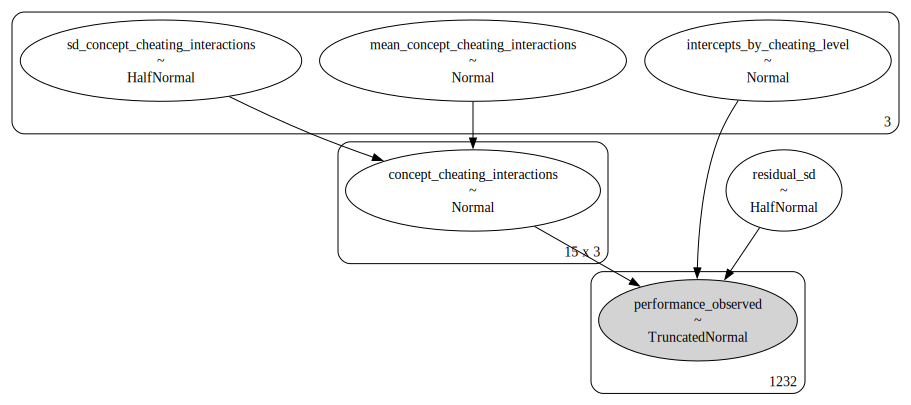

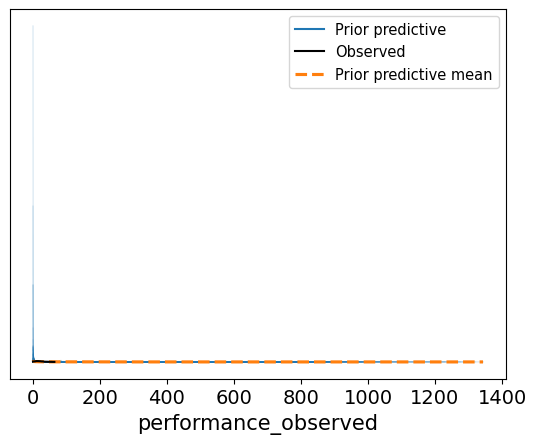

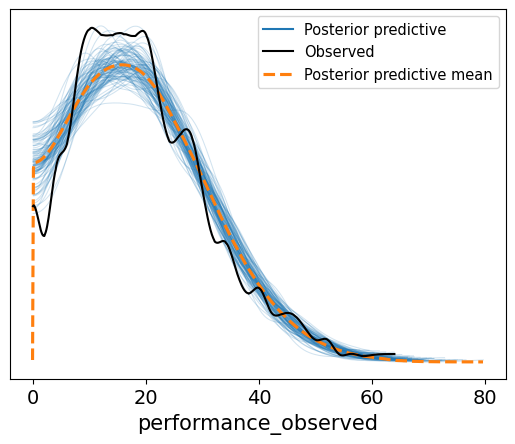

In [3]:
# =============================================================================
# 2. RQ2: PERFORMANCE MODEL
# =============================================================================
print("Fitting RQ2: Performance Model...")
performance_model = build_cheating_model(df, concepts, outcome_col='performance', lower=0)
trace_performance = sample_model(performance_model)
print("Done.")

with performance_model:
    ppc_performance_prior = pm.sample_prior_predictive(model=performance_model)
    ppc_performance_posterior = pm.sample_posterior_predictive(trace_performance, random_seed=42)

az.plot_ppc(ppc_performance_prior, group='prior', observed=True)
az.plot_ppc(ppc_performance_posterior, num_pp_samples=100)
pm.model_to_graphviz(performance_model)


Fitting RQ3: Experience Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts_by_cheating_level, mean_concept_cheating_interactions, sd_concept_cheating_interactions, concept_cheating_interactions, residual_sd]


Output()

Sampling 4 chains for 2_500 tune and 1_500 draw iterations (10_000 + 6_000 draws total) took 593 seconds.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [concept_cheating_interactions, experience_observed, intercepts_by_cheating_level, mean_concept_cheating_interactions, residual_sd, sd_concept_cheating_interactions]


Done.


Sampling: [experience_observed]


Output()

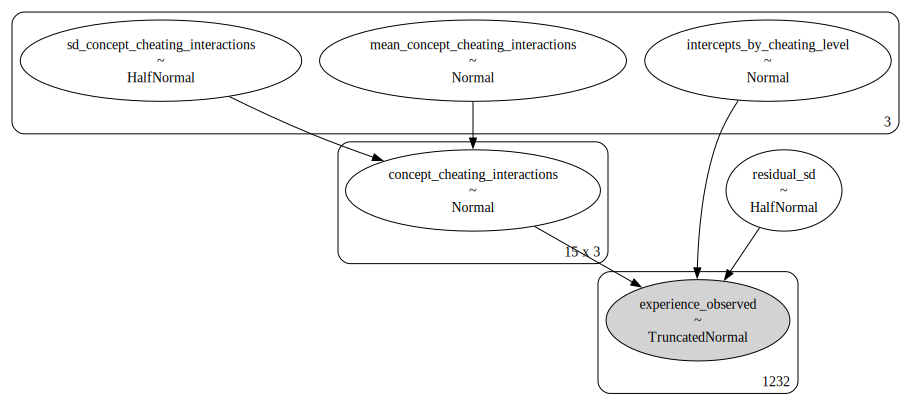

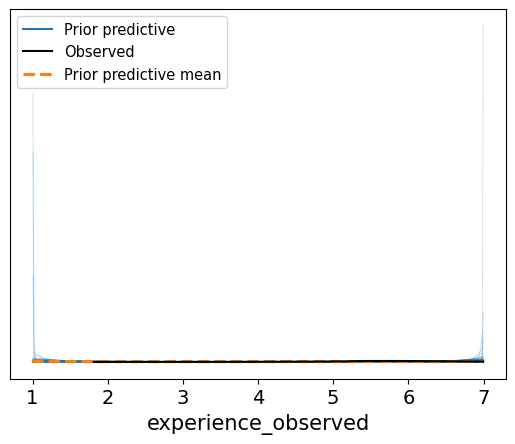

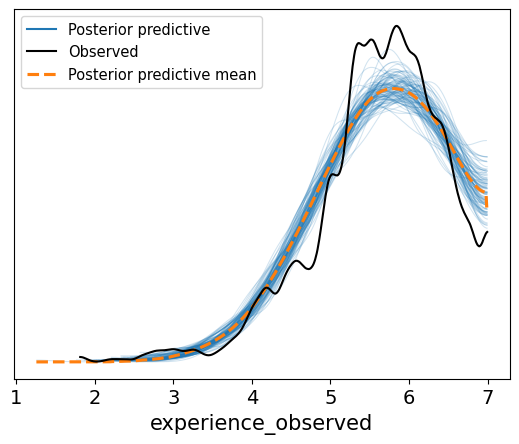

In [4]:
# =============================================================================
# 3. RQ3: EXPERIENCE MODEL
# =============================================================================
print("Fitting RQ3: Experience Model...")
experience_model = build_cheating_model(df, concepts, outcome_col='experience', lower=1, upper=7)
trace_experience = sample_model(experience_model)
print("Done.")

with experience_model:
    ppc_experience_prior = pm.sample_prior_predictive(model=experience_model)
    ppc_experience_posterior = pm.sample_posterior_predictive(trace_experience, random_seed=42)

az.plot_ppc(ppc_experience_prior, group='prior', observed=True)
az.plot_ppc(ppc_experience_posterior, num_pp_samples=100)
pm.model_to_graphviz(experience_model)


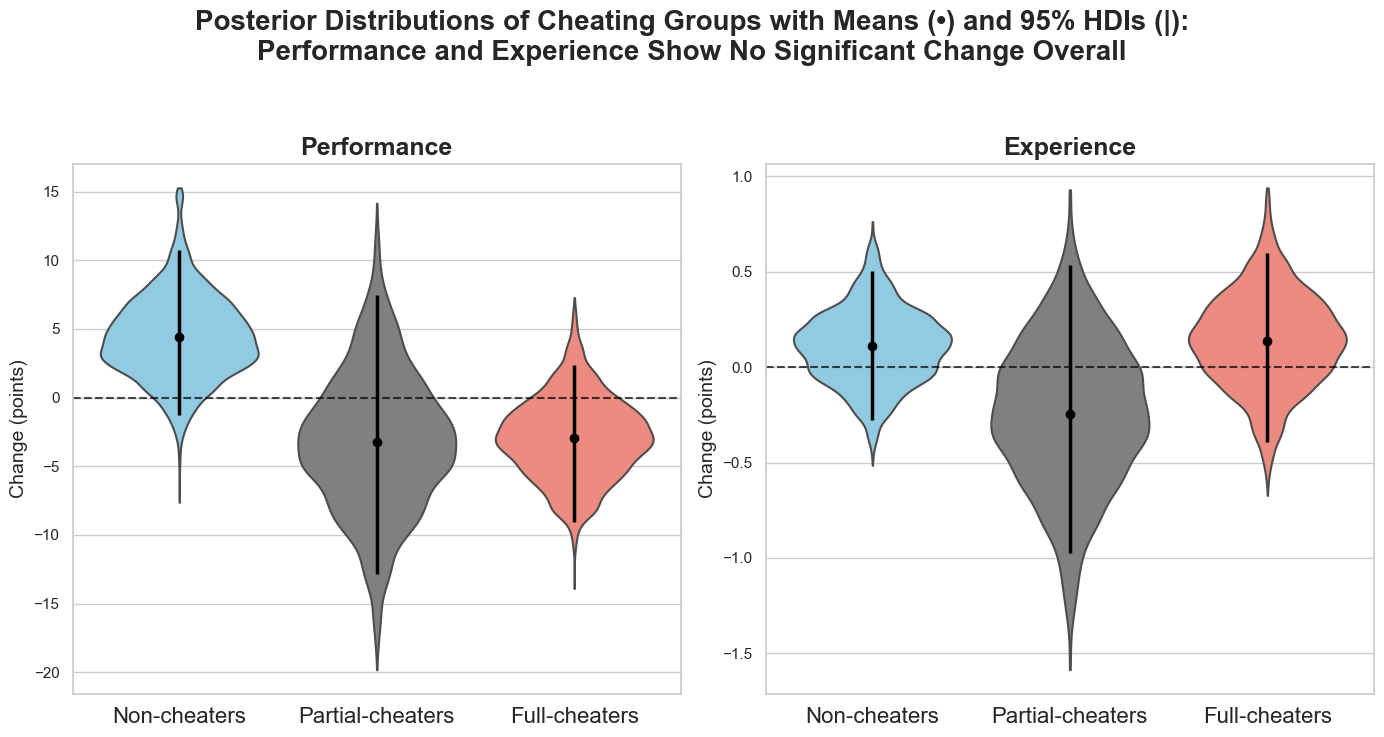

In [5]:
# =============================================================================
# 4. COMBINED IMPACT VIOLIN PLOT (PERFORMANCE & EXPERIENCE)
# =============================================================================
def create_combined_impact_violin(trace_perf, trace_exp, concepts):
    sns.set_theme(style="whitegrid")
    
    def extract_effects(trace, outcome):
        intercepts = trace.posterior['intercepts_by_cheating_level'].values.reshape(-1, 3)
        interactions = trace.posterior['concept_cheating_interactions'].values.reshape(-1, len(concepts), 3)
        rows = []
        for i, group in enumerate(['Non-cheaters','Partial-cheaters','Full-cheaters']):
            concept_effects = [(intercepts[:,i]+interactions[:,j,i])-intercepts[:,i] for j in range(len(concepts))]
            for e in np.mean(concept_effects, axis=0):
                rows.append({'outcome': outcome, 'group': group, 'effect': e})
        return rows
    
    df_violin = pd.DataFrame(extract_effects(trace_perf, 'Performance') +
                             extract_effects(trace_exp, 'Experience'))
    
    palette = {"Non-cheaters":"skyblue","Partial-cheaters":"gray","Full-cheaters":"salmon"}
    fig, axes = plt.subplots(1,2,figsize=(14,7), sharey=False)
    
    for ax, outcome in zip(axes,['Performance','Experience']):
        data = df_violin[df_violin['outcome']==outcome]
        sns.violinplot(data=data, x="group", y="effect", palette=palette, inner=None, cut=0, ax=ax,
                       linewidth=1.5, saturation=0.8)
        for i, group in enumerate(palette.keys()):
            subset = data[data['group']==group]['effect'].values
            if len(subset)>0:
                mean_val = np.mean(subset)
                hdi_low,hdi_high = az.hdi(subset,hdi_prob=0.95)
                ax.plot(i, mean_val,'o', color='black', markersize=6, zorder=3)
                ax.vlines(i,hdi_low,hdi_high,color='black', lw=2.5)
        ax.axhline(0,color="black",lw=1.5,linestyle="--",alpha=0.7)
        ax.set_title(outcome,fontsize=18,fontweight="bold")
        ax.tick_params(axis='x',labelsize=16)
        ax.set_xlabel("")
        ax.set_ylabel("Change (points)",fontsize=14)
    
    fig.suptitle("Posterior Distributions of Cheating Groups with Means (•) and 95% HDIs (|):\n"
                 "Performance and Experience Show No Significant Change Overall",
                 fontsize=20,color="black", alpha=0.85, fontweight="bold", y=1.05)
    plt.tight_layout()
    plt.show()

create_combined_impact_violin(trace_performance, trace_experience, concepts)


In [7]:
# =============================================================================
# 5. POSTERIOR SUMMARY TABLE
# =============================================================================
def create_posterior_summary(trace_perf, trace_exp, concepts):
    def calc_stats(trace, outcome):
        intercepts = trace.posterior['intercepts_by_cheating_level'].values.reshape(-1,3)
        interactions = trace.posterior['concept_cheating_interactions'].values.reshape(-1,len(concepts),3)
        results=[]
        for i, group in enumerate(['Non-cheaters','Partial-cheaters','Full-cheaters']):
            control=intercepts[:,i]; intervention=intercepts[:,i]+np.mean(interactions[:,:,i],axis=1)
            diff = intervention-control
            results.append({
                'Outcome': outcome,
                'Group': group,
                'Control_Mean': f"{np.mean(control):.2f}",
                'Control_95HDI': f"[{az.hdi(control,0.95)[0]:.2f}, {az.hdi(control,0.95)[1]:.2f}]",
                'Intervention_Mean': f"{np.mean(intervention):.2f}",
                'Intervention_95HDI': f"[{az.hdi(intervention,0.95)[0]:.2f}, {az.hdi(intervention,0.95)[1]:.2f}]",
                'Difference_Mean': f"{np.mean(diff):.2f}",
                'Difference_95HDI': f"[{az.hdi(diff,0.95)[0]:.2f}, {az.hdi(diff,0.95)[1]:.2f}]"
            })
        return results
    summary_df = pd.DataFrame(calc_stats(trace_perf,'Performance') + calc_stats(trace_exp,'Experience'))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    print(summary_df)
    return summary_df

summary_table = create_posterior_summary(trace_performance, trace_experience, concepts)


       Outcome             Group Control_Mean   Control_95HDI  \
0  Performance      Non-cheaters         9.12   [3.19, 15.06]   
1  Performance  Partial-cheaters        17.91   [7.97, 27.71]   
2  Performance     Full-cheaters        29.99  [24.46, 35.63]   
3   Experience      Non-cheaters         5.71    [5.33, 6.09]   
4   Experience  Partial-cheaters         5.98    [5.23, 6.71]   
5   Experience     Full-cheaters         5.74    [5.28, 6.23]   

  Intervention_Mean Intervention_95HDI Difference_Mean Difference_95HDI  
0             13.52     [12.04, 14.93]            4.40   [-1.24, 10.74]  
1             14.69     [12.35, 17.09]           -3.22   [-12.81, 7.44]  
2             27.05     [25.13, 28.87]           -2.94    [-9.04, 2.38]  
3              5.82       [5.72, 5.92]            0.11    [-0.28, 0.50]  
4              5.73       [5.56, 5.90]           -0.25    [-0.98, 0.53]  
5              5.88       [5.71, 6.05]            0.14    [-0.39, 0.59]  


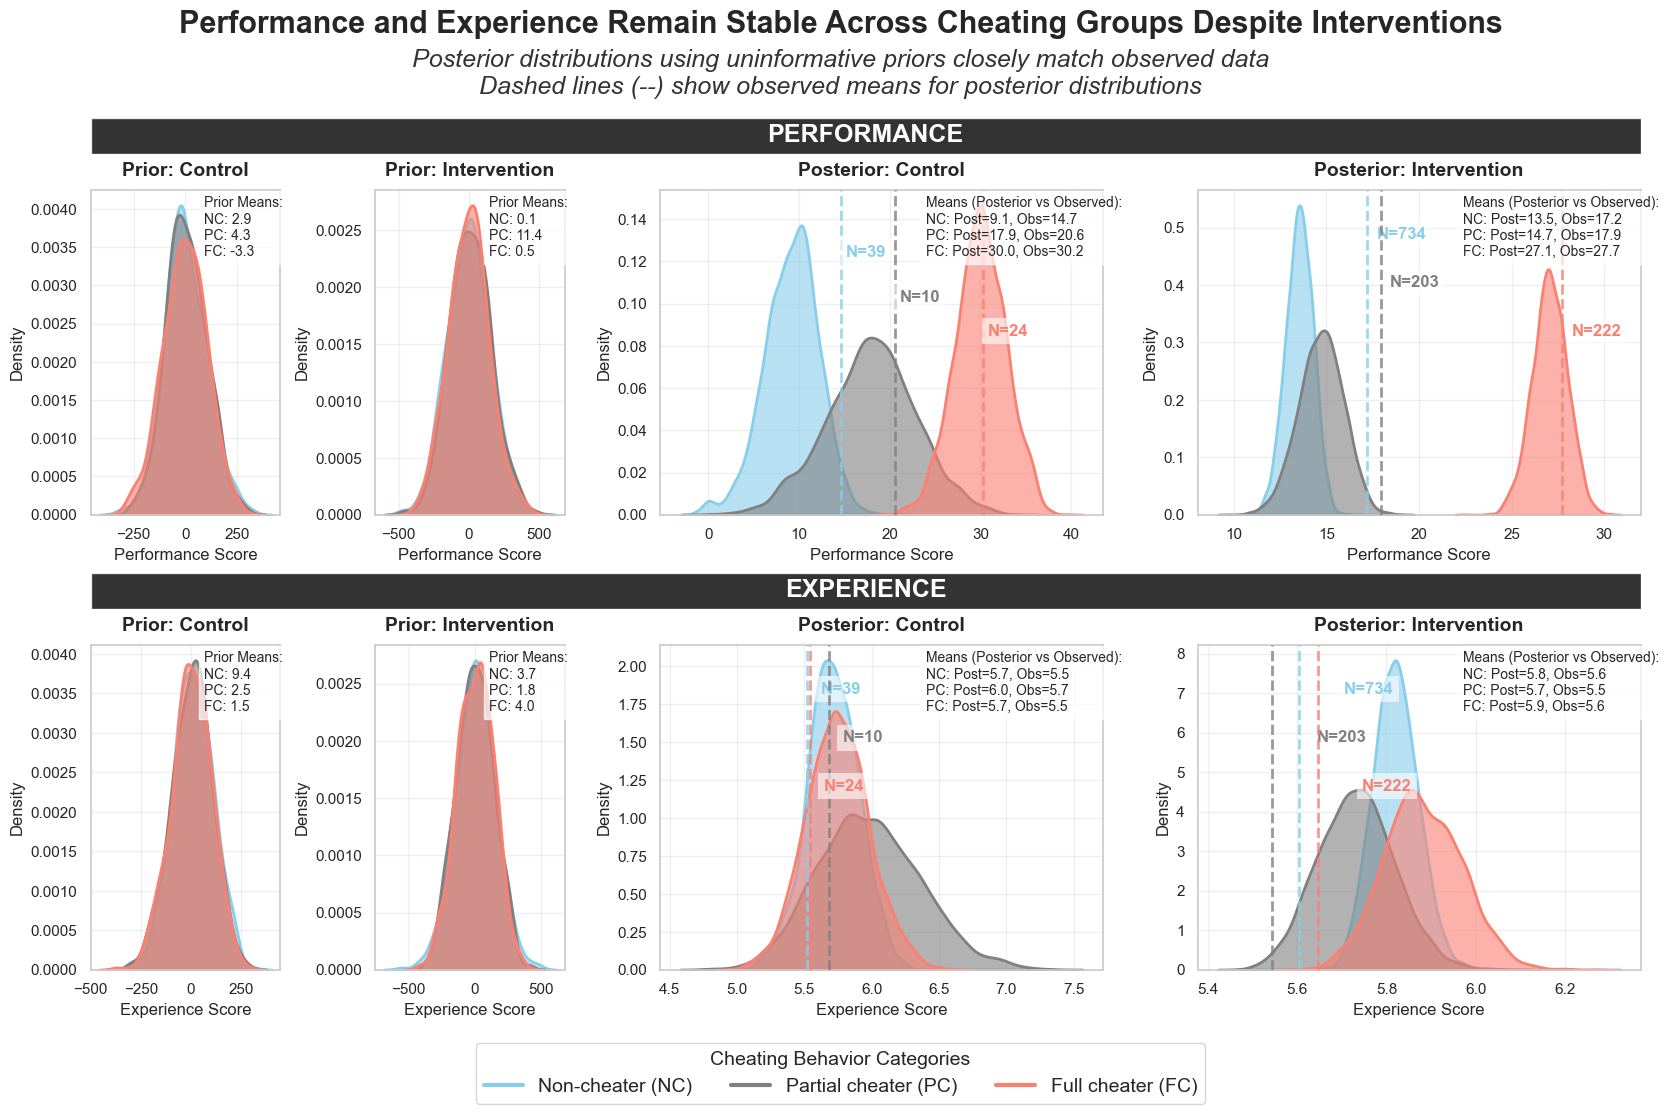

In [8]:
# =============================================================================
# 6. COMBINED PERFORMANCE & EXPERIENCE VALIDATION PLOT FUNCTION
# =============================================================================
def plot_combined_validation(trace_perf, trace_exp, ppc_perf_prior, ppc_exp_prior, df, concepts):
    """
    Combined validation plot for Performance and Experience outcomes.
    Prior vs posterior distributions, observed means, and group counts.
    """
    sns.set_theme(style="whitegrid")
    categories = ['Non-cheater (NC)', 'Partial cheater (PC)', 'Full cheater (FC)']
    short_cats = ['NC', 'PC', 'FC']
    colors = ['skyblue', 'gray', 'salmon']
    
    outcomes = {
        'Performance': {'trace': trace_perf, 'ppc_prior': ppc_perf_prior, 'col_name': 'performance'},
        'Experience': {'trace': trace_exp, 'ppc_prior': ppc_exp_prior, 'col_name': 'experience'}
    }
    
    fig = plt.figure(figsize=(20, 12))
    gs_main = fig.add_gridspec(2, 4, width_ratios=[0.6,0.6,1.4,1.4], hspace=0.4, wspace=0.3, top=0.85, bottom=0.2)
    
    for outcome_idx, (outcome_name, cfg) in enumerate(outcomes.items()):
        # Header colored bar
        header_ax = fig.add_subplot(gs_main[outcome_idx, :])
        header_ax.set_position([header_ax.get_position().x0, header_ax.get_position().y1 + 0.03,
                                header_ax.get_position().width, 0.03])
        header_ax.add_patch(plt.Rectangle((0,0),1,1,facecolor='black',alpha=0.8, transform=header_ax.transAxes))
        header_ax.text(0.5,0.5,outcome_name.upper(), ha='center', va='center', fontsize=18, fontweight='bold',
                       color='white', transform=header_ax.transAxes)
        header_ax.axis('off')

        # Extract posterior and prior samples
        intercepts_samples = cfg['trace'].posterior['intercepts_by_cheating_level'].values.reshape(-1,3)
        interactions_samples = cfg['trace'].posterior['concept_cheating_interactions'].values.reshape(-1,len(concepts),3)
        prior_intercepts = cfg['ppc_prior'].prior['intercepts_by_cheating_level'].values.reshape(-1,3)
        prior_interactions = cfg['ppc_prior'].prior['concept_cheating_interactions'].values.reshape(-1,len(concepts),3)

        # Compute prior/posterior control and intervention
        posterior_control = intercepts_samples
        posterior_intervention = intercepts_samples + interactions_samples.mean(axis=1)
        prior_control = prior_intercepts
        prior_intervention = prior_intercepts + prior_interactions.mean(axis=1)

        control_obs = df[df['concept']=='control'].groupby('cheating_behavior')[cfg['col_name']].mean()
        intervention_obs = df[df['concept']!='control'].groupby('cheating_behavior')[cfg['col_name']].mean()

        plot_configs = [
            {'data': prior_control, 'obs': control_obs, 'title':'Prior: Control', 'col':0, 'is_prior':True, 'is_control':True},
            {'data': prior_intervention, 'obs': intervention_obs, 'title':'Prior: Intervention', 'col':1, 'is_prior':True, 'is_control':False},
            {'data': posterior_control, 'obs': control_obs, 'title':'Posterior: Control', 'col':2, 'is_prior':False, 'is_control':True},
            {'data': posterior_intervention, 'obs': intervention_obs, 'title':'Posterior: Intervention', 'col':3, 'is_prior':False, 'is_control':False}
        ]

        for cfg_plot in plot_configs:
            ax = fig.add_subplot(gs_main[outcome_idx, cfg_plot['col']])
            group_data = df[df['concept']=='control'] if cfg_plot['is_control'] else df[df['concept']!='control']
            group_counts = group_data['cheating_behavior'].value_counts().sort_index()
            plot_means, observed_means = [], []

            for i, (cat, sc, color) in enumerate(zip(categories, short_cats, colors)):
                sns.kdeplot(cfg_plot['data'][:,i], ax=ax, color=color, fill=True, alpha=0.6, linewidth=2)
                plot_mean = cfg_plot['data'][:,i].mean()
                plot_means.append(plot_mean)

                if not cfg_plot['is_prior'] and i in cfg_plot['obs'].index:
                    obs_mean = cfg_plot['obs'].iloc[i]
                    observed_means.append(obs_mean)
                    ax.axvline(obs_mean,color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=3)
                    y_pos = ax.get_ylim()[1]*(0.85 - i*0.15)
                    offset = 0.5 if outcome_name=='Performance' else 0.1
                    ax.text(obs_mean+offset, y_pos, f"N={group_counts.get(i,0)}",
                            fontsize=12,fontweight='bold',color=color,
                            bbox=dict(facecolor='white',alpha=0.6,edgecolor='none'))
            ax.set_title(cfg_plot['title'], fontweight='bold', fontsize=14, pad=10)
            ax.set_xlabel(f'{outcome_name} Score', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.tick_params(axis='both', labelsize=11)
            ax.grid(True, alpha=0.3)

            stats_text = '\n'.join([f'{sc}: Post={post:.1f}, Obs={obs:.1f}' 
                                    for sc, post, obs in zip(short_cats, plot_means, observed_means)]) \
                         if not cfg_plot['is_prior'] else '\n'.join([f'{sc}: {mean:.1f}' for sc, mean in zip(short_cats, plot_means)])
            header = 'Means (Posterior vs Observed):\n' if not cfg_plot['is_prior'] else 'Prior Means:\n'
            ax.text(0.6,0.98,f'{header}{stats_text}', transform=ax.transAxes, va='top', fontsize=10,
                    bbox=dict(facecolor='white',alpha=0.7))

    # Unified legend and titles
    legend_elements = [plt.Line2D([0],[0], color=color, linewidth=3, label=cat) 
                       for cat, color in zip(categories, colors)]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5,0.08), ncol=3, fontsize=14, title='Cheating Behavior Categories', title_fontsize=14)
    plt.suptitle('Performance and Experience Remain Stable Across Cheating Groups Despite Interventions',
                 fontsize=22, fontweight='bold', y=1)
    plt.figtext(0.5,0.93,'Posterior distributions using uninformative priors closely match observed data\nDashed lines (--) show observed means for posterior distributions',
                ha='center', fontsize=18, style='italic', color='black', alpha=0.8)
    plt.tight_layout(rect=[0,0.08,1,0.86])
    plt.show()

plot_combined_validation(
    trace_perf=trace_performance,
    trace_exp=trace_experience,
    ppc_perf_prior=ppc_performance_prior,
    ppc_exp_prior=ppc_experience_prior,
    df=df,
    concepts=concepts
)